# BRANCH PREDICTING TRANSFORMER

This is the code for the construction of the Branch Predicting Transformer. Instead of calling common libraries for transformer implementation (i.e. torch.nn.multiheadedattention), I am writing them from scratch. This is so we can trust that the PyTorch library is not inserting under-the-hood functionality that we will want to (but be unable to) replicate in verilog later. Doing it this way ensures that we will have a complete understanding of how the transformer operates and will thus make implementing the model in verilog much more direct.

In [ ]:
!pip install torchview
!pip install graphviz

from torchview import draw_graph

In [ ]:
import time
import torch

import numpy as np
import random
from ast import literal_eval
from tqdm import tqdm, trange

import copy
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

print(f"Device name set to: {device}")

Device name set to: cuda:0


In [ ]:
class Config:
    def __init__(self):
        self.model_type = 'gpt'
        self.n_layer = 3
        self.n_head = 4
        self.d_embd = 64
        self.d_attn = 64
        self.d_mlp = 128
        self.n_regs = 16
        self.vocab_size = 981           # number of mnemonics in x86
        self.context_size = 20
        self.embd_pdrop = 0.1
        self.resid_pdrop = 0.1
        self.attn_pdrop = 0.1
        self.weight_decay = 0.1
        self.learning_rate = 3e-4
        self.betas = (0.9, 0.95)
        self.grad_norm_clip = 1.0

config = Config()

Here, I'm making the mask that will be applied to the attention matrix to block out certain relationships that we don't want to allow the transformer to recognize, and pass through certain ones that we do want it to recognize.

The input to the attention block will be the matrix X, the embedding of each register and instruction. The embeddings of context_size instructions will be concatenated to the embedding matrix of n_regs registers, leading to an input matrix `X` of size *(`context_size` + `n_regs`) x (`n_emb`)*.

This mask fundamentally distinguishes this transformer from a translation or GPT-type transformer, since it is neither bidirectional nor autoregressive.

This graphic should clarify the reasoning behind the masking:

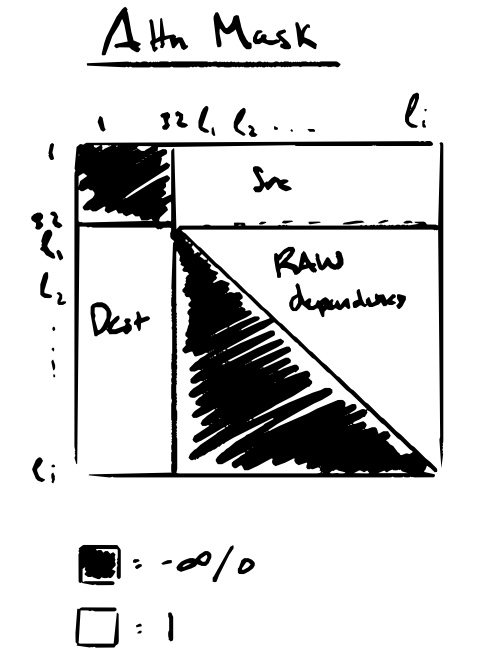


**src block**: a register is affecting the execution of an instruction, i.e. it is a source register

**dest block**: the execution of an instruction is affecting a register, i.e. it is a destination register

**RAW dependency**: the execution of an earlier instruction is affecting the execution of a later instruction, i.e. there is a read-after-write dependency between the two.

torch.Size([1, 1, 36, 36])


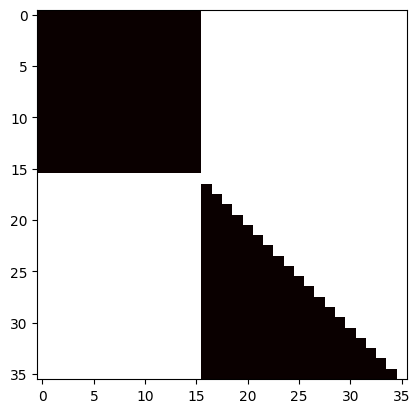

In [ ]:
C = config.context_size
R = config.n_regs
S = C + R
causal_mask = torch.ones((1, 1, S, S))
causal_mask[0,0,:16,:16] = 0
causal_mask[0,0,16:,16:] = torch.triu(causal_mask[:,:,16:,16:])
# causal_mask = torch.triu(causal_mask)


# Visualization
plt.imshow(causal_mask[0, 0].cpu().numpy(), cmap='hot', interpolation='nearest')
# You should pass the following assertion
assert causal_mask.shape == (1, 1, S, S)
for i in range(C):
    assert torch.sum(causal_mask[0, 0, i + 17:, i + 16]) == 0
    assert torch.sum(causal_mask[0, 0, :16, :16]) == 0
assert torch.sum(causal_mask) ==  (2*C * R) + C * (C + 1) / 2
print(causal_mask.shape)

### Making the Attention Block
With the attention mask initialized, we can now write the attention block.

The attention block takes in sequences of token embeddings (e.g. sentences), which are tensors of dimension `(B, N, D)` where
* `B` is the batchsize (number of sequences)
* `N` is the number of tokens
* `D` is the embedding dimension

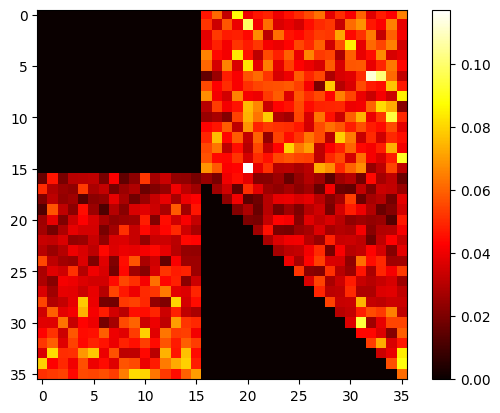

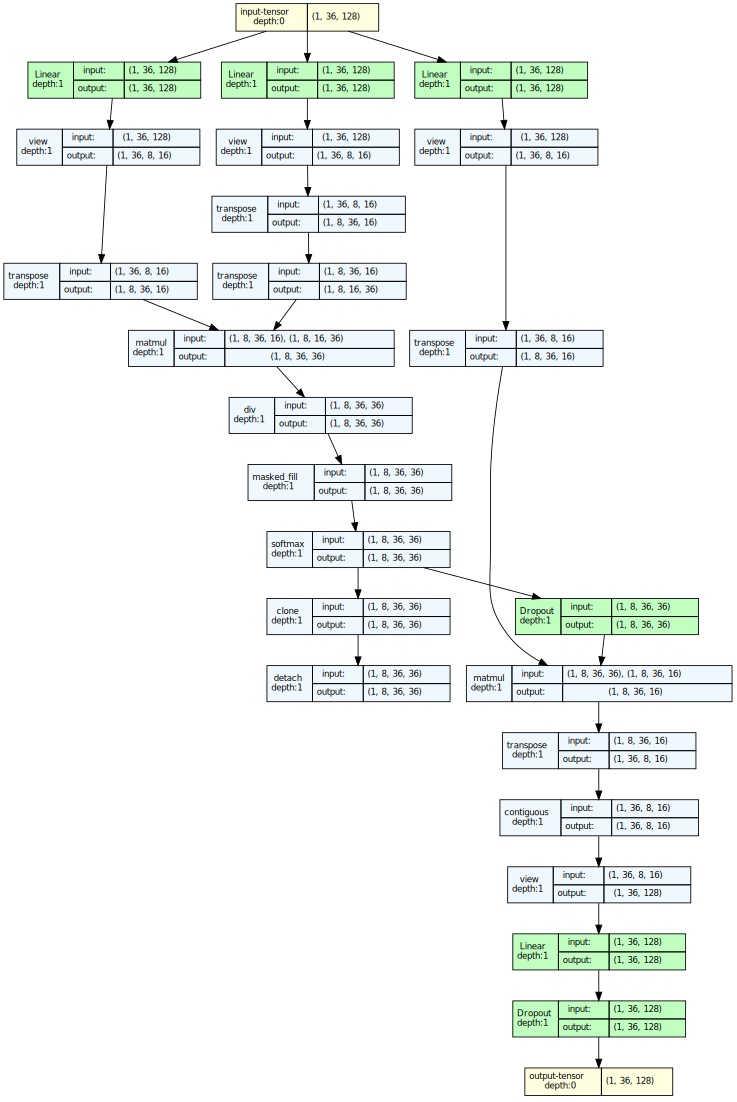

In [ ]:
class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.d_embd % config.n_head == 0
        assert config.d_attn % config.n_head == 0
        self.n_head = config.n_head
        self.d_embd = config.d_embd
        self.d_attn = config.d_attn
        self.attn_map = None # for caching the attention map

        # key, query, value projections for all heads
        self.q_proj = nn.Linear(config.d_embd, config.d_attn)
        self.k_proj = nn.Linear(config.d_embd, config.d_attn)
        self.v_proj = nn.Linear(config.d_embd, config.d_embd)

        # output projection
        self.o_proj = nn.Linear(config.d_embd, config.d_embd)

        # dropout regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)


    def forward(self, x):
        B, N, D = x.size() # batch size, sequence length, embedding dimensionality (d_embd)
        nh = self.n_head
        A = self.d_attn
        hs = A // nh
        hsv = D // nh

        # calculate query, key, values for all heads in batch (we are splitting after the projections)
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        assert Q.shape == (B, N, A)
        assert K.shape == (B, N, A)
        assert V.shape == (B, N, D)

        # Split the queries, keys, and values in multiple heads
        Qh = Q.view(B, N, nh, hs)
        Kh = K.view(B, N, nh, hs)
        Vh = V.view(B, N, nh, hsv)

        assert Qh.shape == (B, N, nh, hs)
        assert Kh.shape == (B, N, nh, hs)
        assert Vh.shape == (B, N, nh, hsv)

        # Swap the axes to allow for the matrix multiplication
        Qh = Qh.transpose(1, 2)
        Kh = Kh.transpose(1, 2)
        Vh = Vh.transpose(1, 2)

        assert Qh.shape == (B, nh, N, hs)
        assert Kh.shape == (B, nh, N, hs)
        assert Vh.shape == (B, nh, N, hsv)

        # Self-attention scaled dot product on Q and K^T; (B, nh, N, hs) x (B, nh, hs, N) -> (B, nh, N, N)
        scaled_dot_product = torch.matmul(Qh, Kh.transpose(-2, -1)) / (hs ** 0.5)
        masked_scaled_dot_product = scaled_dot_product.masked_fill(causal_mask[:, :, :N, :N].to(x.device) == 0, float('-inf'))
        att = F.softmax(masked_scaled_dot_product, dim=-1)

        # Clone the attention maps
        with torch.no_grad():
            self.attn_map = att.clone().detach() # cache the attention map for visualization

        # Apply dropout to the attention, for regularization purposes
        att = self.attn_dropout(att)
        assert self.attn_map.shape == (B, nh, N, N), f"Attention map has the wrong shape, should be {(B, nh, N, N)}, but received {attention.attn_map.shape}"

        # Attend to the values to get the output of the self-attention mechanism
        y = torch.matmul(att, Vh)
        assert y.shape == (B, nh, N, hsv)

        # Rearrange the output to have the same shape as the input before splitting
        y = y.transpose(1, 2).contiguous().view(B, N, D)
        assert y.shape == (B, N, D)

        # Apply the output projection o_proj to get the final output of the self-attention mechanism
        y = self.o_proj(y)

        # Apply dropout to the output, for regularization purposes
        y = self.resid_dropout(y)
        return y

# Now we test the self-attention module with a random input
random_input = torch.randn(1, config.context_size + config.n_regs, config.d_embd).to(device)
attention = SelfAttention(config).to(device)
output = attention(random_input)

# model should pass the following assertions: the output shape should be the same as the input shape
assert output.shape == random_input.shape
assert attention.attn_map is not None

# Visualize the attention map
plt.imshow(attention.attn_map[0, 0].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

assert torch.mean(attention.attn_map.sum(dim=-1) - 1.0) < 1e-6, "Attention map does not sum to 1 on the token dim"
# for i in range(attention.attn_map.size(-1)):
#     assert torch.sum(attention.attn_map[:, :, i, i + 1:]) < 1e-6, "Causal mask is not applied correctly"

# Visualize the model graph for the self-attention block
model_graph = draw_graph(attention, random_input, depth=1)
model_graph.visual_graph

3 remaining steps in building branch predicting transformer:
1. Construct MLP blocks
2. Construct Transformer blocks (Attention + MLP)
3. Construct GPT-like model (stacking Transformer blocks + unnembedding)

### MLP Block

1. The first layer will project the D dimensional input to d_mlp dimensions
2. The d_mlp dimensional hidden representation will go through GELU activation
3. The second layer send the d_mlp dimensional representation back to D dimensions
4. Apply a dropout layer toward the end.

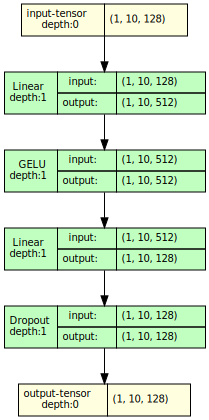

In [ ]:
class MLPBlock(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.d_embd = config.d_embd
        self.d_mlp = config.d_mlp
        self.n_output = config.d_embd

        # layer 1
        self.fc1 = nn.Linear(self.d_embd, self.d_mlp)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(self.d_mlp, self.n_output)
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        # Take the four steps described above
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

# Now we test the MLP block with a random input
random_input = torch.randn(1, 10, config.d_embd).to(device)
mlp = MLPBlock(config).to(device)
output = mlp(random_input)

assert output.shape == random_input.shape

# Visualize the model graph for the MLP block
model_graph = draw_graph(mlp, random_input, depth=1)
model_graph.visual_graph

### Transformer Block
This transformer block follows exactly from the pseudocode in the Google Deepmind paper on transformers, *Formalized Algorithms for Transformers, Phuong and Hutter (2022)*.

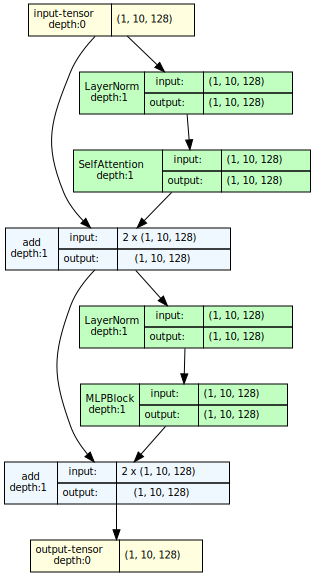

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.d_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.d_embd)
        self.mlp = MLPBlock(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

# Now we test the transformer block with a random input
random_input = torch.randn(1, 10, config.d_embd).to(device)
transformer_block = TransformerBlock(config).to(device)
output = transformer_block(random_input)

assert output.shape == random_input.shape

# Visualize the model graph for the transformer block
model_graph = draw_graph(transformer_block, random_input, depth=1)
model_graph.visual_graph

In [ ]:
class DecoderEmbedding(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        # Initialize the token and positional embeddings
        self.weight_inst_emb = nn.Embedding(config.vocab_size, config.d_embd)
        self.weight_pos_emb = nn.Embedding(config.context_size, config.d_embd)
        self.weight_src1_emb = nn.Embedding(config.n_regs + 1, config.d_embd)
        self.weight_src2_emb = nn.Embedding(config.n_regs + 1, config.d_embd)
        self.weight_src3_emb = nn.Embedding(config.n_regs + 1, config.d_embd)
        self.weight_dst1_emb = nn.Embedding(config.n_regs + 1, config.d_embd)
        self.weight_dst2_emb = nn.Embedding(config.n_regs + 1, config.d_embd)
        self.weight_imm_emb = nn.Linear(1, config.d_embd)
        self.weight_mem_emb = nn.Linear(1, config.d_embd)
        self.weight_rf_emb = nn.Linear(1, config.d_embd)

    def forward(self, data):

        regfile, instseq = data




        B, E, N = instseq.size()
        assert regfile.shape == (B, 1, 16)
        assert instseq.shape == (B, 8, N)

        assert N <= self.config.context_size, f"Cannot forward sequence of length {N}, largest context size is {self.config.context_size}"
        assert E == 8 # contains opcode, source register (3), destination register (2), immediate, and memory ptr information

        regfile = torch.transpose(regfile, 1, 2)

        assert regfile.shape == (B, self.config.n_regs, 1), f"regfile shape should be (1, {self.config.n_regs}, 1), but received {regfile.shape}"
        src1 = instseq[:, 1, :]
        src2 = instseq[:, 2, :]
        src3 = instseq[:, 3, :]
        dst1 = instseq[:, 4, :]
        dst2 = instseq[:, 5, :]
        imm = instseq[:, 6, :].unsqueeze(2)
        mem = instseq[:, 7, :].unsqueeze(2)
        instseq = instseq[:, 0, :]

        # Create a tensor with the positions of the instructions in the sequence (used for positional embeddings)
        pos = torch.arange(0, N, dtype=torch.long, device=device).unsqueeze(0)

        # Compute the token and positional embeddings
        inst_emb = self.weight_inst_emb(instseq)
        pos_emb = self.weight_pos_emb(pos)
        src1_emb = self.weight_src1_emb(src1)
        src2_emb = self.weight_src2_emb(src2)
        src3_emb = self.weight_src3_emb(src3)
        dst1_emb = self.weight_dst1_emb(dst1)
        dst2_emb = self.weight_dst2_emb(dst2)
        imm_emb = self.weight_imm_emb(imm.type(torch.float32))
        mem_emb = self.weight_mem_emb(mem.type(torch.float32))
        rf_emb = self.weight_rf_emb(regfile.type(torch.float32))

        assert inst_emb.shape == (B, N, self.config.d_embd)
        assert pos_emb.shape == (1, N, self.config.d_embd)
        assert src1_emb.shape == (B, N, self.config.d_embd)
        assert src2_emb.shape == (B, N, self.config.d_embd)
        assert src3_emb.shape == (B, N, self.config.d_embd)
        assert dst1_emb.shape == (B, N, self.config.d_embd)
        assert dst2_emb.shape == (B, N, self.config.d_embd)
        assert imm_emb.shape == (B, N, self.config.d_embd)
        assert mem_emb.shape == (B, N, self.config.d_embd)
        assert rf_emb.shape == (B, config.n_regs, self.config.d_embd)

        # Sum the embeddings
        x = inst_emb + pos_emb + src1_emb + src2_emb + src3_emb + dst1_emb + dst2_emb + imm_emb + mem_emb
        # Concatenate instruction embeddings to the register file embeddings
        x = torch.cat([rf_emb, x], dim=1)

        assert x.shape == (B, N + self.config.n_regs, self.config.d_embd)

        return x

# Now we test the BPT model with a random input
random_inst_input = torch.randint(0, config.vocab_size, (1, 1, 10)).to(device)
random_src1_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_src2_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_dst_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_imm_input = torch.randint(0, 100, (1, 1, 10)).to(device)
random_rf_input = torch.randint(0, 100, (1, 1, 32)).to(device)
# concatenate all instruction information into single tensor
random_inst_input = torch.cat([random_inst_input, random_src1_input, random_src2_input, random_dst_input, random_imm_input], 1)
assert random_inst_input.shape == (1, 5, 10)
assert random_rf_input.shape == (1, 1, 32)
random_rf_input = random_rf_input.expand(1, 5, 32)
assert random_rf_input.shape == (1, 5, 32)


# form into tuple for data input
random_data_input = torch.cat([random_rf_input, random_inst_input], 2)

assert random_data_input.shape == (1, 5, 42)



# embedder = DecoderEmbedding(config).to(device)
# output = embedder(random_data_input)

# # the output shape should be the same batch, sequence lengths and width 2
# assert output.shape == (1, 42, config.d_embd)

# # Visualize the model graph for the BPT model
# model_graph = draw_graph(embedder, random_data_input, depth=1)
# model_graph.visual_graph


### CRAFTING THE TRANSFORMER

Here we need to introduce the concept of a vocabulary, which is the set of tokens the model can process. In this case, the various "words" this language model can process is the number of instructions in the chosen instruction set architecture. We will use `K` to denote the size of the vocabulary. For RV32I, that is `K = 47`. We will be using x86, which has many more, ~1000. We will use `R` to denote the size of the register file (`R = 16` here).

We want the transformer to take in the state of the register file (16 registers), a sequence of tokens (a list of integers in $[K]$, marking their indices in the vocabulary), two sequences of instruction source registers (lists of integers in $[R]$), a sequence of instruction destination registers (a list of integers in $[R]$), and output a sequence of the instructions, each encoding the probability that the instruction will branch.


The transformers works as follows:
1. It takes in sequences of instructions from the vocabulary set and converts them to embeddings (e.g. a batch of B sequences of length N will be embedded to an embedding of tensor of shape `(B, N, D)` where each token has a D-dimensional vector embedding representation).
2. The instruction embeddings are added with positional, source, and destination embeddings of the same size.
3. The sum of embeddings is passed through several transformer blocks, with a final output also of the size `(B, N, D)`
4. The transformer output is being fed into a fully connected head, projecting the D-dimensional representation of each instruction into a 2-dimensional logit vector.


Total number of parameters: 933376


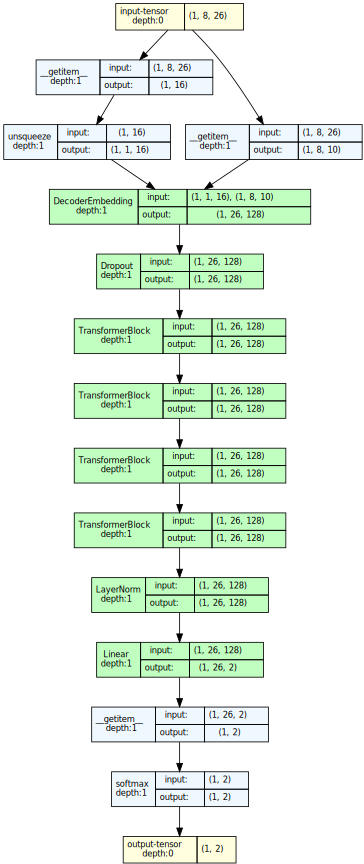

In [ ]:
class BPT(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        # Initialize the decoder embedding
        self.embedding = DecoderEmbedding(config)

        # Initialize the transformer blocks
        self.blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layer)])

        # Initialize the layer normalization and dropout
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.ln_f = nn.LayerNorm(config.d_embd)

        # Initialize the final linear head
        self.lm_head = nn.Linear(config.d_embd, 2, bias=False)

    def forward(self, data):
        B, E, N = data.size()
        assert N > self.config.n_regs
        N = N - config.n_regs
        assert E == 8
        assert N <= self.config.context_size, f"Cannot forward sequence of length {N}, largest context size is {self.config.context_size}"

        regfile = data[:,0,:16].unsqueeze(1)
        instseq = data[:,:,16:]

        assert regfile.shape == (B, 1, 16)
        assert instseq.shape == (B, 8, N)

        data = [regfile, instseq]

        # Send input through the embedding process
        x = self.embedding(data)

        # Apply dropout to the input
        x = self.dropout(x)

        # Pass the sequence through the transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply the final layer normalization
        x = self.ln_f(x)

        # Compute the logits by applying the linear layer
        logits = self.lm_head(x)
        branch_prediction = logits[:,N + self.config.n_regs - 1,:] # forget register encodings

        branch_prediction = F.softmax(branch_prediction, dim=-1)
        assert branch_prediction.shape == (B, 2)

        return branch_prediction

    def init_weights(self, module):
        # Initialize the weights of the model
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config):
        # Configure the optimizer for training by seperating weight decay for certain parameters
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                if pn.endswith('bias'):
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" % (str(param_dict.keys() - union_params), )
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

# Now we test the BPT model with a random input
random_inst_input = torch.randint(0, config.vocab_size, (1, 1, 10)).to(device)
random_src1_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_src2_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_src3_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_dst1_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_dst2_input = torch.randint(0, config.n_regs, (1, 1, 10)).to(device)
random_mem_input = torch.randint(0, 100, (1, 1, 10)).to(device)
random_imm_input = torch.randint(0, 100, (1, 1, 10)).to(device)
random_rf_input = torch.randint(0, 100, (1, 1, 16)).to(device)
# concatenate all instruction information into single tensor
random_inst_input = torch.cat([random_inst_input, random_src1_input, random_src2_input, random_src3_input, random_dst1_input, random_dst2_input, random_imm_input, random_mem_input], 1)
assert random_inst_input.shape == (1, 8, 10)
assert random_rf_input.shape == (1, 1, 16)
random_rf_input = random_rf_input.expand(1, 8, 16)
assert random_rf_input.shape == (1, 8, 16)


# form into tuple for data input
random_data_input = torch.cat([random_rf_input, random_inst_input], 2)

assert random_data_input.shape == (1, 8, 26)

bpt = BPT(config).to(device)
output = bpt(random_data_input)

# the output shape should be the same batch, sequence lengths and width 2
assert output.shape == (1, 2)

# calculate total number of parameters
total_params = sum(p.numel() for p in bpt.parameters())
print(f"Total number of parameters: {total_params}")

# Visualize the model graph for the BPT model
model_graph = draw_graph(bpt, random_data_input, depth=1)
model_graph.visual_graph


### TRAINING DATA RETRIEVAL

Here, we'll parse the files outputted by Pin, and format them into tensors of appropriate size to be run through the transformer for training and testing.

In [ ]:
def hex_to_signed_int(hex_str, bits=64):
    # Convert a hex string to a signed integer using two's complement.
      val = int(hex_str, 16)
      if val >= 2**(bits - 1):
          val -= 2**bits
      return val

ex = "FFFFFFFFFFFFFFF0"
print(hex_to_signed_int(ex))

def parse_instruction_line(line, regfile):
    """Parses one line from the instruction file."""
    assert len(regfile) == 16 # regfile should be a dictionary of all register values


    def reg_to_index(reg):
      register_to_index = {
      'rax': 1, 'rbx': 2, 'rcx': 3, 'rdx': 4,
      'rsi': 5, 'rdi': 6, 'rbp': 7, 'rsp': 8,
      'r8': 9, 'r9': 10, 'r10': 11, 'r11': 12,
      'r12': 13, 'r13': 14, 'r14': 15, 'r15': 16
      }
      return register_to_index[reg] if reg in register_to_index else 0

    tokens = line.strip().split(" | ")
    rip = hex_to_signed_int(tokens[0], 64)          # instruction pointer register here
    regfile['rip'] = rip
    inst = tokens[1]                                # assembly string here

    # instruction data here
    inst_data = tokens[1].split()
    inst = inst_data[0]
    imm = 0
    src = 0
    dst = 0
    mem = 0
    for i in range(1, len(inst_data)):
      if i == 1:
        dst = [reg_to_index(normalize_register(inst_data[i]))] if dst == 0 else 0   # tentatively assign a destination register if nontrivial
      else:
        src = [reg_to_index(normalize_register(inst_data[i]))] if src == 0 else 0   # tentatively assign a source register if nontrivial
      if inst_data[i].startswith("0x"):
        imm = hex_to_signed_int(inst_data[i], 64)                               # tentatively assign an immediate value
      elif inst_data[i] == "ptr":
        start = inst_data[i + 1].index('[')
        end = inst_data[i + 1].index(']')
        mem = inst_data[i + 1][start + 1:end]
        mem = eval(mem, {}, regfile)                  # assuming no non-normalized registers are used to compute memory address

    # branch info here
    branch_data = tokens[2].split()
    is_branch = int(branch_data[0])
    branch_taken = int(branch_data[1])

    # immediate data here
    if (tokens[3] != "{no imm}"):
      imm = hex_to_signed_int(tokens[3], 64)

    # source data here
    if (tokens[4] != "{no source}"):
      src = tokens[4].split()
      src = [reg_to_index(normalize_register(x)) for x in src] if src != 0 else 0

    # destination data here
    if (tokens[5] != "{no dest}"):
      dst = tokens[5].split()
      dst = [reg_to_index(normalize_register(x)) for x in dst] if dst != 0 else 0



    return inst, imm, src, dst, mem, is_branch, branch_taken

def normalize_register(reg: str) -> str:
    """Normalize any of first 16 x86/x86-64 register's alias to its canonical 64-bit form."""
    reg = reg.lower()

    # Mapping for classic registers (a, b, c, d families)
    low_byte_map = {
        'al': 'rax', 'ah': 'rax', 'ax': 'rax', 'eax': 'rax',
        'bl': 'rbx', 'bh': 'rbx', 'bx': 'rbx', 'ebx': 'rbx',
        'cl': 'rcx', 'ch': 'rcx', 'cx': 'rcx', 'ecx': 'rcx',
        'dl': 'rdx', 'dh': 'rdx', 'dx': 'rdx', 'edx': 'rdx',
        'sil': 'rsi', 'esi': 'rsi', 'si': 'rsi',
        'dil': 'rdi', 'edi': 'rdi', 'di': 'rdi',
        'bpl': 'rbp', 'ebp': 'rbp', 'bp': 'rbp',
        'spl': 'rsp', 'esp': 'rsp', 'sp': 'rsp',
    }


    # Extended r8-r15 family (e.g., r8d, r8w, r8b → r8)
    for i in range(8, 16):
        base = f"r{i}"
        if reg.startswith(base):
            return base

    if reg.endswith(','):
        reg = reg[:-1]

    # Handle classical registers
    return low_byte_map.get(reg, reg) if reg in low_byte_map else reg

def parse_regfile_line(line):
    """Parses one line from the register file."""
    regs = line.strip().split()
    regfile_values = list(map(lambda x: hex_to_signed_int(x,64), regs))
    return regfile_values

def to_regfile_dict(regfile_values):
    """Converts a list of register values to a dictionary keyed by register name."""
    register_names = [
        'rax', 'rbx', 'rcx', 'rdx',
        'rsi', 'rdi', 'rbp', 'rsp',
        'r8',  'r9',  'r10', 'r11',
        'r12', 'r13', 'r14', 'r15'
    ]

    if len(regfile_values) != len(register_names):
        raise ValueError(f"Expected {len(register_names)} register values, got {len(regfile_values)}")

    return dict(zip(register_names, regfile_values))

def learn_vocabulary(vocab, parsed_inst):
    inst = parsed_inst[0]
    if inst not in vocab:
        vocab[inst] = len(vocab)

def collate_fn(batch):
    """
    Args:
        batch: list of tuples (inst_tensor [5, N], reg_tensor [1, 16], 1)

    Returns:
        batched_inst: [B, 5, N_max]
        batched_reg:  [B, 1, 16]
        labels:       [B]
    """
    inst_seqs, regfiles, labels = zip(*batch)

    # Transpose from [8, N] → [N, 8] for padding
    inst_seqs_t = [seq.transpose(0, 1) for seq in inst_seqs]  # [N, 8]
    padded = pad_sequence(inst_seqs_t, batch_first=True, padding_value=0)  # [B, N_max, 8]
    batched_inst = padded.transpose(1, 2)  # [B, 5, N_max]

    # Stack regfiles
    batched_reg = torch.stack(regfiles)  # [B, 1, 16]
    labels = torch.tensor(labels)  # [B]

    return batched_inst, batched_reg, labels

def search_for_branches(parsed_insts, regfile_states, max_len, vocab):
    """
    Args:
        parsed_insts (List[Dict]): List of parsed instruction dicts, each with keys like
            ['mnemonic', 'src_regs', 'dest_regs', 'imm', 'is_branch']
        regfile_states (List[List[int]]): Each entry is a list of 64-bit reg values (length 16)
        max_len (int): Maximum length of instruction sequence
        vocab (Dict[str, int]): Instruction vocabulary
        regname_to_index (Dict[str, int]): Maps register names to regfile indices

    Returns:
        List of tuples: (inst_tensor [5, N], regfile_tensor [1, 16])
    """
    results = []
    head = 0
    tail = 0
    branch_taken = [int(inst[6]) for inst in parsed_insts]
    isbranch = [int(inst[5]) for inst in parsed_insts]

    def encode_instruction(parsed_inst, vocab):
        """Convert a parsed instruction to a 8-element feature vector."""
        learn_vocabulary(vocab, parsed_inst) # learn instruction if unseen before searching its value in dictionary


        inst = vocab.get(parsed_inst[0])
        imm  = parsed_inst[1]
        src1 = parsed_inst[2][0] if type(parsed_inst[2]) is not int and len(parsed_inst[2]) > 0 else parsed_inst[2]
        src2 = parsed_inst[2][1] if type(parsed_inst[2]) is not int and len(parsed_inst[2]) > 1 else 0
        src3 = parsed_inst[2][2] if type(parsed_inst[2]) is not int and len(parsed_inst[2]) > 2 else 0
        dst1  = parsed_inst[3][0] if type(parsed_inst[3]) is not int and len(parsed_inst[3]) > 0 else parsed_inst[3]
        dst2  = parsed_inst[3][1] if type(parsed_inst[3]) is not int and len(parsed_inst[3]) > 1 else 0
        mem = parsed_inst[4] if parsed_inst[4] else 0
        return [inst, src1, src2, src3, dst1, dst2, imm, mem]

    while tail < len(parsed_insts):
        # Stretch the window if it's too short and no branch encountered
        while head < len(parsed_insts) and (head - tail) < max_len and not isbranch[head - 1]:
            head += 1

        # Slide until we hit a branch or fall off the end
        while head < len(parsed_insts) and (head - tail) == max_len and not isbranch[head - 1]:
            tail += 1
            head += 1

        if head > len(parsed_insts):
            break  # overshot

        # Save tensor from tail to head (inclusive)
        window = parsed_insts[tail:head]
        inst_seq = [encode_instruction(inst, vocab) for inst in window]
        inst_tensor = torch.tensor(inst_seq, dtype=torch.long).transpose(0, -1)         # shape [8, N]
        # pad to max length
        inst_tensor = F.pad(inst_tensor, (0, max_len - inst_tensor.size(1)), value=0)     # shape [8, N_max]
        reg_tensor = torch.tensor(regfile_states[tail],dtype=torch.long).unsqueeze(0)   # shape [1, 16]
        label = torch.tensor(branch_taken[head - 1], dtype=torch.long).unsqueeze(0)     # shape [1,1]
        results.append((inst_tensor, reg_tensor, label))

        if (len(results) % 10000 == 0): print(len(results)," batches completed")
        if (len(results) == 50000): return results

        # Contract the spring
        if head > tail + 1: tail += 1
        else:
          head += 1 # or expand if tail is equal or above head
          tail += 1



    return results


def load_data(inst_filename, rf_filename, instruction_vocab, max_len):
    """
    Processes the input file into regfile and instruction sequence tensors.

    Args:
        file_path (str): Path to the input dump file.
        instruction_vocab (dict): Mapping from instruction string -> vocab index.

    Returns:
        List of tuples: (inst_tensor [5, N], regfile_tensor [1, 16])
    """

    with open(inst_filename, 'r') as inst_file, open(rf_filename, 'r') as rf_file:
      rf_lines = rf_file.readlines()
      num_rf_lines = len(rf_lines)
      inst_lines = inst_file.readlines()
      num_inst_lines = len(inst_lines)
      num_lines = min(num_rf_lines, num_inst_lines)
      inst_lines = inst_lines[:num_lines]
      rf_lines = rf_lines[:num_lines]

    # Pre-parse all lines
    parsed_rf = [parse_regfile_line(line) for line in rf_lines]
    parsed_insts = [parse_instruction_line(line, to_regfile_dict(parsed_rf[i])) for i, line in enumerate(inst_lines)]

    batches = search_for_branches(parsed_insts, parsed_rf, max_len, instruction_vocab)



    return batches

-16


In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
    print(f"You uploaded: {filename}")

Saving cat_ins_small.out to cat_ins_small.out
Saving cat_reg_small.out to cat_reg_small.out
Saving date_ins_small.out to date_ins_small (1).out
Saving date_reg_small.out to date_reg_small (1).out
Saving head_ins_small.out to head_ins_small.out
Saving head_reg_small.out to head_reg_small.out
You uploaded: cat_ins_small.out
You uploaded: cat_reg_small.out
You uploaded: date_ins_small (1).out
You uploaded: date_reg_small (1).out
You uploaded: head_ins_small.out
You uploaded: head_reg_small.out


In [ ]:
inst_filename = "ls_ins_small.out"
rf_filename = "ls_reg_small.out"
cat_inst_filename = "cat_ins_small.out"
cat_reg_filename = "cat_reg_small.out"
pwd_inst_filename = "pwd_ins_small.out"
pwd_reg_filename = "pwd_reg_small_out"
date_inst_filename = "date_ins_small (1).out"
date_reg_filename = "date_reg_small (1).out"
head_inst_filename = "head_ins_small.out"
head_reg_filename = "head_reg_small.out"

instruction_vocab = {}

instruction_line = "15303aee1c31 | lea r8, ptr [rbx+0x21] | 0 0 | 0x15303b0f2a90  | {no source} | rsi "
regfile_line = "0x7ffda808b250 0xFFFFFFFFFFFFFF81 0x7ffda808b240 0x7ffda808b220 0x000000000 0x000000000 0x000000000 0x000000000 0x000000000 0x000000000 0x000000000 0x000000000 0x7ffda808b250 0x000000000 0x000000000 0x000000000 "
parsed_rf = parse_regfile_line(regfile_line)
print("parsed regfile: ",parsed_rf)
regfile_values = to_regfile_dict(parsed_rf)
parsed_instruction = parse_instruction_line(instruction_line, regfile_values)
print("parsed jbe instruction: ",parsed_instruction)

parsed_rf = parse_regfile_line(regfile_line)
regfile1_values = to_regfile_dict(parsed_rf)
parsed_rf = parse_regfile_line(regfile_line)
regfile2_values = to_regfile_dict(parsed_rf)
parsed_rf = parse_regfile_line(regfile_line)
regfile3_values = to_regfile_dict(parsed_rf)
dummy_vocab = {}
dummy_line1 = "15303aee1c73 | mov rax, qword ptr [rdx] | 0 0 | {no imm} | rdx  | rax "
dummy_line2 = "15303aee1c76 | call rax, rax | 0 0 | {no imm} | rax rax  | r_status_flags "
dummy_line3 = "15303aee1c79 | jz 0x15303aee1cb0 | 1 0 | {no imm} | r15 rip rsp  | rip rsp "
learn_vocabulary(dummy_vocab, parse_instruction_line(dummy_line1, regfile1_values))
learn_vocabulary(dummy_vocab, parse_instruction_line(dummy_line2, regfile2_values))
print("dummy vocab: ", dummy_vocab)
learn_vocabulary(dummy_vocab, parse_instruction_line(dummy_line3, regfile3_values))
print("dummy vocab: ", dummy_vocab)


ls_batches = load_data(inst_filename, rf_filename, instruction_vocab, config.context_size)
cat_batches = load_data(cat_inst_filename, cat_reg_filename, instruction_vocab, config.context_size)
pwd_batches = load_data(pwd_inst_filename, pwd_reg_filename, instruction_vocab, config.context_size)
date_batches = load_data(date_inst_filename, date_reg_filename, instruction_vocab, config.context_size)
head_batches = load_data(head_inst_filename, head_reg_filename, instruction_vocab, config.context_size)

def to_ds(batches):
  instructions = [batch[0] for batch in batches]
  instructions = torch.stack(instructions)
  regfiles = [batch[1] for batch in batches]
  regfiles = torch.stack(regfiles)
  labels = [batch[2] for batch in batches]
  labels = torch.stack(labels)
  regfiles = regfiles.expand(num_batches, 8, 16)
  labels = labels.unsqueeze(1)
  labels = labels.expand(num_batches, 8, 1)
  data = torch.cat([regfiles, instructions, labels], 2)
  return data


ls_data = to_ds(ls_batches)
cat_data = to_ds(cat_batches)
pwd_data = to_ds(pwd_batches)
date_data = to_ds(date_batches)
head_data = to_ds(head_batches)


training_ds = torch.cat([ls_data[:40000,:,:],cat_data[:40000,:,:], pwd_data[:40000,:,:], date_data[:40000,:,:], head_data[:40000,:,:]], dim=0)
eval_ds = torch.cat([ls_data[40000:40401,:,:],cat_data[40000:40401,:,:], pwd_data[40000:40401,:,:], date_data[40000:40401,:,:], head_data[40000:40401,:,:]], dim=0)

training_dl = DataLoader(training_ds, batch_size=32, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=32, shuffle=False)

parsed regfile:  [140727422595664, -127, 140727422595648, 140727422595616, 0, 0, 0, 0, 0, 0, 0, 0, 140727422595664, 0, 0, 0]
parsed jbe instruction:  ('lea', 23296893463184, 0, [5], -94, 0, 0)
dummy vocab:  {'mov': 0, 'call': 1}
dummy vocab:  {'mov': 0, 'call': 1, 'jz': 2}


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-da87ad601ae3>", line 39, in <cell line: 0>
    ls_batches = load_data(inst_filename, rf_filename, instruction_vocab, config.context_size)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-11-471c00d80ac1>", line 244, in load_data
    parsed_insts = [parse_instruction_line(line, to_regfile_dict(parsed_rf[i])) for i, line in enumerate(inst_lines)]
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-11-471c00d80ac1>", line 244, in <listcomp>
    parsed_insts = [parse_instruction_line(line, to_regfile_dict(parsed_rf[i])) for i, line in enumerate(inst_lines)]
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
import torch.utils

# B,D,8,N
batch = 500
# print("branch label: ",supersmall_batches[batch][2])
# print("sequence length: ",len(supersmall_batches[batch][0][0]))
print("dictionary: ",instruction_vocab)
# print("sequence: ",batches[batch])


dictionary:  {'mov': 0, 'push': 1, 'sub': 2, 'rdtsc': 3, 'shl': 4, 'or': 5, 'lea': 6, 'test': 7, 'jz': 8, 'add': 9, 'jmp': 10, 'cmp': 11, 'jbe': 12, 'sar': 13, 'jnbe': 14, 'neg': 15, 'jnz': 16, 'cmovnz': 17, 'jnb': 18, 'nop': 19, 'jb': 20, 'shr': 21, 'xor': 22, 'movzx': 23, 'and': 24, 'movsxd': 25, 'ret': 26, 'call': 27, 'cdqe': 28, 'pop': 29, 'setnz': 30, 'syscall': 31, 'cpuid': 32, 'jle': 33, 'xgetbv': 34, 'bt': 35, 'jns': 36, 'pxor': 37, 'movdqu': 38, 'pcmpeqb': 39, 'pmovmskb': 40, 'bsf': 41, 'data16': 42, 'imul': 43, 'movdqa': 44, 'psubb': 45, 'js': 46, 'movaps': 47, 'movd': 48, 'punpcklbw': 49, 'punpcklwd': 50, 'pshufd': 51, 'jnle': 52, 'por': 53, 'cmovbe': 54, 'movups': 55, 'cmovnbe': 56}


### TRAIN THE MODEL

Here, we'll train the model on the collected data. We'll train for 10 epochs and collect data as we go for analysis.

In [ ]:
class BranchTakenTrainer():

    def __init__(self, model, optimizer, train_dl, eval_dl):
        self.model = model
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.eval_dl = eval_dl

    def eval_model_last_token(self):
        self.model.eval()
        eval_loss_ls = []
        eval_accuracy_ls = []
        for x in self.eval_dl:

            with torch.no_grad():
                logit = self.model(x[:, :, :-1].to(device))
                labels = x[:, 0, -1].float().to(device)
                loss = F.cross_entropy(logit[:, 0], labels)
                accuracy = torch.mean((torch.argmax(logit[:, -1], dim=-1) == labels).float())
            eval_loss_ls.append(loss.item())
            eval_accuracy_ls.append(accuracy.item())

        self.model.train()
        return np.mean(eval_loss_ls), np.mean(eval_accuracy_ls)

    def train(self, epochs):
        total_steps = 0

        train_loss_ls, train_acc_ls = [], []
        val_loss_ls, val_acc_ls = [], []
        recorded_steps = []

        checkpoints = []
        train_loss_seg, train_acc_seg = [], []

        epoch_iters = tqdm(range(epochs))
        for epoch in epoch_iters:
            for x in self.train_dl:
                total_steps += 1

                # take last token in x to label sequence
                labels = x[:, 0, -1].float().to(device)

                # take all tokens EXCEPT last token (label) and send through model
                logits = self.model(x[:, :, :-1].to(device))

                # calculate cross entropy loss
                loss = F.cross_entropy(logits[:, 0], labels)

                loss.backward()

                # gradient clipping, gradient descent step, reset gradients to 0
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), config.grad_norm_clip)
                self.optimizer.step()
                self.optimizer.zero_grad()

                train_loss_seg.append(loss.item())
                train_acc_seg.append(torch.mean((torch.argmax(logits[:, -1], dim=-1) == labels).float()).item())

                if total_steps % 100 == 0:

                    train_loss_ls.append(np.mean(train_loss_seg))
                    train_acc_ls.append(np.mean(train_acc_seg))
                    train_loss_seg, train_acc_seg = [], []

                    val_loss, val_acc = self.eval_model_last_token()
                    val_loss_ls.append(val_loss)
                    val_acc_ls.append(val_acc)

                    recorded_steps.append(total_steps)

                    if total_steps % 100 == 0:
                        epoch_iters.set_postfix_str(f"Epoch: {epoch}, Steps: {total_steps}, Train Loss: {train_loss_ls[-1]:.4g}, Train Accuracy: {train_acc_ls[-1]:.4g}, Eval Loss: {val_loss:.4g}, Eval Accuracy: {val_acc:.4g}")
            checkpoints.append(copy.deepcopy(self.model.state_dict()))

        ret_meta = {
            "train_loss": train_loss_ls,
            "train_acc": train_acc_ls,
            "val_loss": val_loss_ls,
            "val_acc": val_acc_ls,
            "recorded_steps": recorded_steps,
            "checkpoints": checkpoints
        }
        return ret_meta

In [ ]:
config = Config()
model = BPT(config).to(device)
model.init_weights(bpt)
optimizer = model.configure_optimizers(config)

trainer = BranchTakenTrainer(model, optimizer, training_dl, eval_dl)
training_meta = trainer.train(30)

100%|██████████| 30/30 [10:23<00:00, 20.77s/it, Epoch: 29, Steps: 37500, Train Loss: 53.5, Train Accuracy: 0.02469, Eval Loss: 47.86, Eval Accuracy: 0.03606]


### VISUALIZE TRAINING RESULTS
Next we visualize the training trajectory of the models (eval / train) loss & acc.

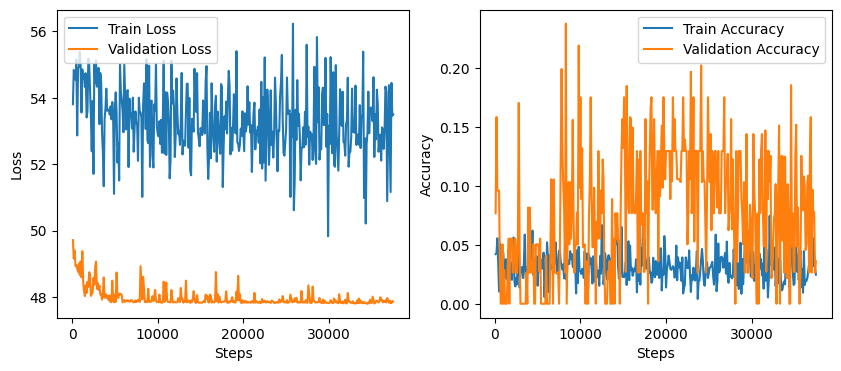

In [ ]:
def visualize_training_meta(meta):

    train_loss = meta['train_loss']
    train_acc = meta['train_acc']
    val_loss = meta['val_loss']
    val_acc = meta['val_acc']

    recorded_steps = meta['recorded_steps']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(recorded_steps, train_loss, label='Train Loss')
    plt.plot(recorded_steps, val_loss, label='Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recorded_steps, train_acc, label='Train Accuracy')
    plt.plot(recorded_steps, val_acc, label='Validation Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

visualize_training_meta(training_meta)

### TESTING

Here, we make some testing data sets on other linux boot programs and test branch prediction accuracy on this new data.

10000  batches completed
20000  batches completed
30000  batches completed
40000  batches completed
50000  batches completed
torch.Size([50000, 8, 37])


<ipython-input-36-9a3a6812e930>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_logits = model(torch.tensor(test_input)[:, :, :-1].to(device))


Accuracy: 0.8100799918174744
Predicted: 0.556439995765686
Branched: 0.4978399872779846


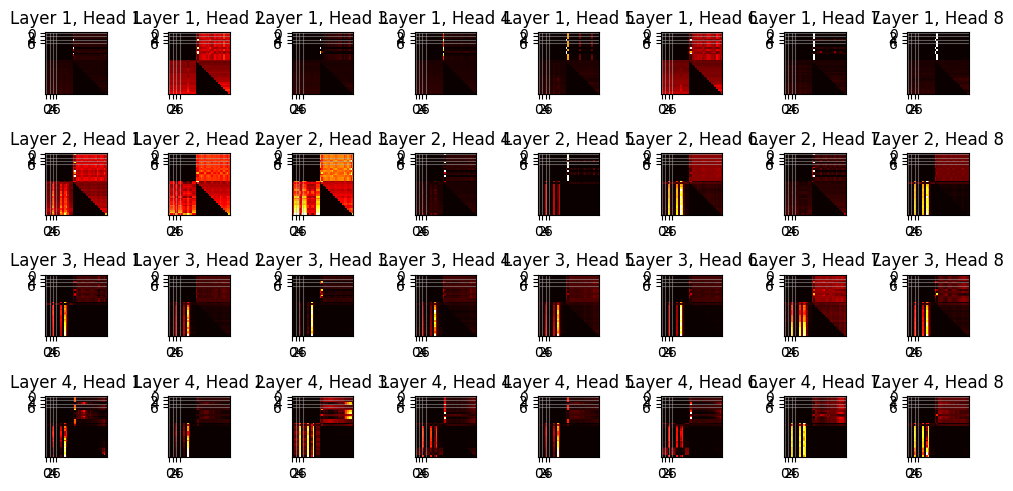

In [ ]:
accuracy = 0
predicted = 0
branched = 0
model.eval()

inst_filename = "env_ins_small.out"
reg_filename = "env_reg_small.out"

batches = load_data(inst_filename, reg_filename, instruction_vocab, config.context_size)
ds = to_ds(batches)

print(ds.size())

for i in range(len(ds)):
  test_input = ds[i,:,:].unsqueeze(0)


  with torch.no_grad():
      output_logits = model(torch.tensor(test_input)[:, :, :-1].to(device))

  label = test_input[0, 0, -1]
  prediction = output_logits[0][0] > 0.5
  predicted += prediction
  branched += label == 1
  accurate = prediction == label
  accuracy += accurate

print(f"Accuracy: {accuracy / ds.size()[0]}")
print(f"Predicted: {predicted / ds.size()[0]}")
print(f"Branched: {branched / ds.size()[0]}")

figure = plt.figure(figsize=(10, 5))
gs = figure.add_gridspec(len(model.blocks), config.n_head)

for layer_ind, layer in enumerate(model.blocks):
    for head in range(config.n_head):
        ax = figure.add_subplot(gs[layer_ind, head])
        ax.imshow(layer.attn.attn_map[0, head].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
        ax.set_title(f"Layer {layer_ind + 1}, Head {head + 1}")
        ax.set_xticks(np.arange(len(test_input[0]), step=2))
        ax.set_yticks(np.arange(len(test_input[0]), step=2))
        ax.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()